In [1525]:
import sklearn

In [1526]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [1527]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


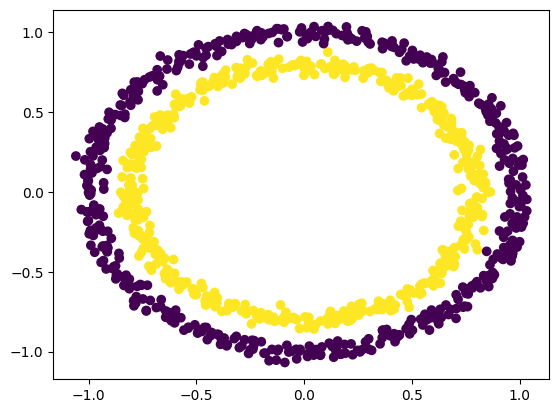

In [1528]:
# visualize

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

In [1529]:
import torch

torch.__version__

'2.6.0+cu118'

In [1530]:
# Convert ndarrays to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [1531]:
# Split data into training

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1532]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [1533]:
import torch.nn as nn

In [1534]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        ## alternative way of implementing
        # self.two_linear_layers = nn.Sequential(
        #   nn.Linear(in_features=2, out_features=5),
        #   nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model = CircleModel()

model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [1535]:
next(model.parameters()).to(device)

tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [1536]:
# torch.manual_seed(42)

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [1537]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [1538]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(
        f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}"
    )
    print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
    print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
    print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [1539]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [1540]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [1541]:
X_train = X_train.to(device=device)
X_test = X_test.to(device=device)
y_train = y_train.to(device=device)
y_test = y_test.to(device=device)

device, X_train.device, X_test.device, y_train.device, y_test.device

('cuda',
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [1542]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

epochs = 100

# model_0=model.to(device)

for epoch in range(epochs):
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss fn BCEWithLogitsLoss() expects logits. BCELoss() expects probabilities
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {test_loss:.5f}")
            print(f"accuracy: {acc:.2f} | test_accuracy: {test_acc:.2f}\n")

epoch: 0 | loss: 0.69796 | test_loss: 0.69440
accuracy: 51.88 | test_accuracy: 58.00

epoch: 10 | loss: 0.69590 | test_loss: 0.69305
accuracy: 51.25 | test_accuracy: 53.00

epoch: 20 | loss: 0.69490 | test_loss: 0.69254
accuracy: 51.62 | test_accuracy: 49.50

epoch: 30 | loss: 0.69435 | test_loss: 0.69236
accuracy: 51.12 | test_accuracy: 49.50

epoch: 40 | loss: 0.69401 | test_loss: 0.69232
accuracy: 50.88 | test_accuracy: 51.00

epoch: 50 | loss: 0.69378 | test_loss: 0.69234
accuracy: 50.25 | test_accuracy: 50.00

epoch: 60 | loss: 0.69362 | test_loss: 0.69239
accuracy: 50.00 | test_accuracy: 51.50

epoch: 70 | loss: 0.69351 | test_loss: 0.69246
accuracy: 50.25 | test_accuracy: 51.00

epoch: 80 | loss: 0.69342 | test_loss: 0.69254
accuracy: 49.88 | test_accuracy: 50.00

epoch: 90 | loss: 0.69336 | test_loss: 0.69262
accuracy: 49.88 | test_accuracy: 53.00



In [1543]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)

if Path("helper_functions.py").is_file():
    print("function already exists")
else:
    print("downlaoding function")
    requests = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

from helper_functions import plot_predictions, plot_decision_boundary

function already exists


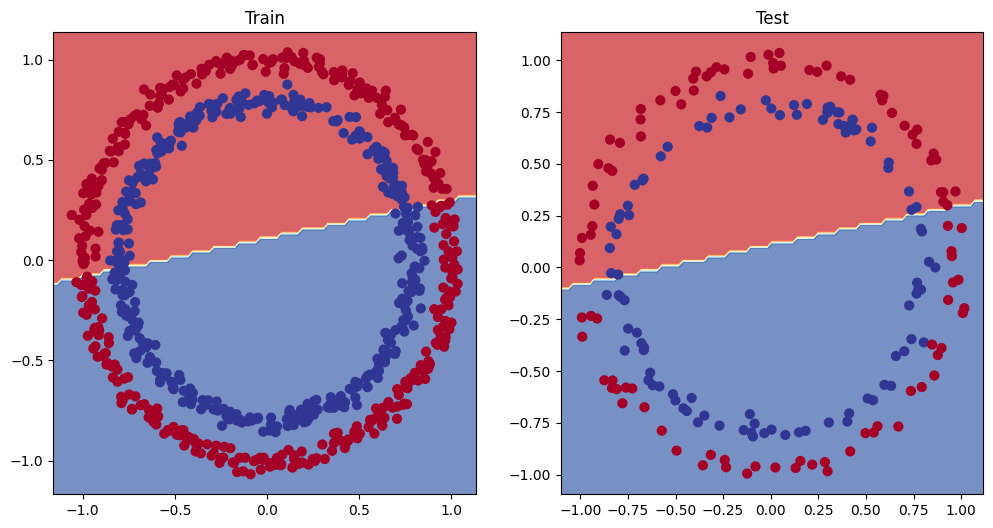

In [1544]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [1545]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)

In [1546]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [1547]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {loss:.5f}")
            print(f"accuracy: {acc:.2f} | test_accuracy: {test_acc:.2f}")

epoch: 0 | loss: 0.69396 | test_loss: 0.69396
accuracy: 50.88 | test_accuracy: 51.00
epoch: 10 | loss: 0.69369 | test_loss: 0.69369
accuracy: 50.25 | test_accuracy: 50.00
epoch: 20 | loss: 0.69351 | test_loss: 0.69351
accuracy: 50.12 | test_accuracy: 49.50
epoch: 30 | loss: 0.69339 | test_loss: 0.69339
accuracy: 50.50 | test_accuracy: 48.00
epoch: 40 | loss: 0.69329 | test_loss: 0.69329
accuracy: 50.38 | test_accuracy: 49.00
epoch: 50 | loss: 0.69322 | test_loss: 0.69322
accuracy: 49.88 | test_accuracy: 50.00
epoch: 60 | loss: 0.69317 | test_loss: 0.69317
accuracy: 49.38 | test_accuracy: 51.50
epoch: 70 | loss: 0.69312 | test_loss: 0.69312
accuracy: 49.38 | test_accuracy: 50.50
epoch: 80 | loss: 0.69309 | test_loss: 0.69309
accuracy: 50.12 | test_accuracy: 50.00
epoch: 90 | loss: 0.69307 | test_loss: 0.69307
accuracy: 50.50 | test_accuracy: 48.50


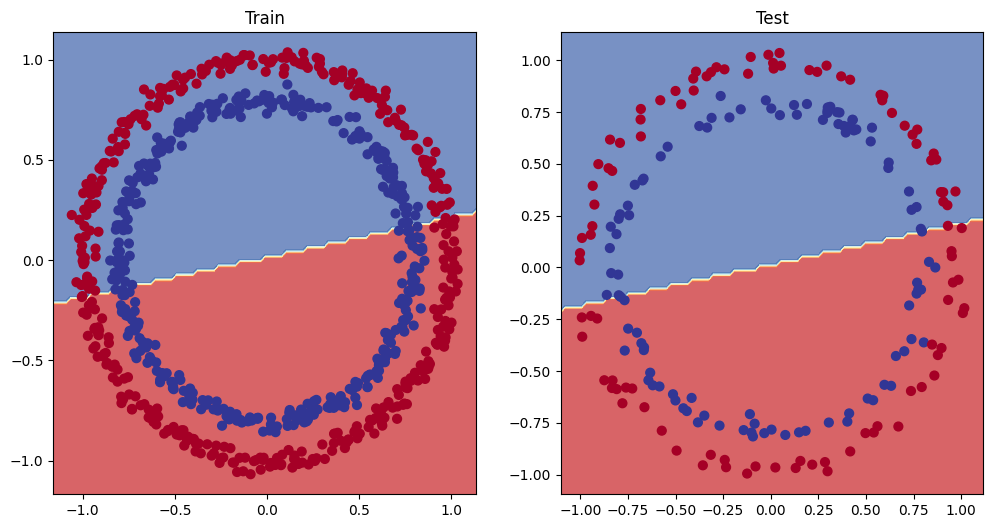

In [1548]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [1549]:
# Create some data

weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression.shape, y_regression.shape, X[:5], y[:5]

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [1550]:
train_split = int(0.8 * len(X_regression))


X_train_regression, y_train_regression = (
    X_regression[:train_split],
    y_regression[:train_split],
)
X_test_regression, y_test_regression = (
    X_regression[train_split:],
    y_regression[train_split:],
)

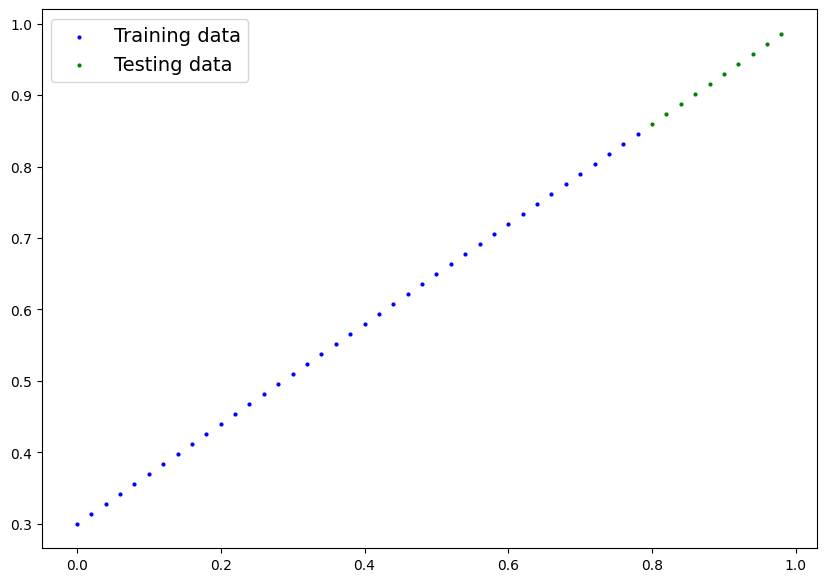

In [1551]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression,
)

In [1552]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [1553]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [1554]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train_regression = X_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_train_regression = y_train_regression.to(device)
y_test_regression = y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_preds = model_2(X_train_regression)

    loss = loss_fn(y_preds, y_train_regression)
    # acc = accuracy_fn(y_test, y_te)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")

epoch: 0 | loss: 0.7579175233840942 | test_loss: 0.5414274334907532
epoch: 10 | loss: 0.1444512903690338 | test_loss: 0.02177971601486206
epoch: 20 | loss: 0.14237533509731293 | test_loss: 0.05598727986216545
epoch: 30 | loss: 0.13193140923976898 | test_loss: 0.043146710842847824
epoch: 40 | loss: 0.09436959773302078 | test_loss: 0.01933634839951992
epoch: 50 | loss: 0.10256387293338776 | test_loss: 0.017531603574752808
epoch: 60 | loss: 0.09328223764896393 | test_loss: 0.008431685157120228
epoch: 70 | loss: 0.09108927100896835 | test_loss: 0.0342753604054451
epoch: 80 | loss: 0.07879956066608429 | test_loss: 0.008622688241302967
epoch: 90 | loss: 0.06615864485502243 | test_loss: 0.01868867315351963


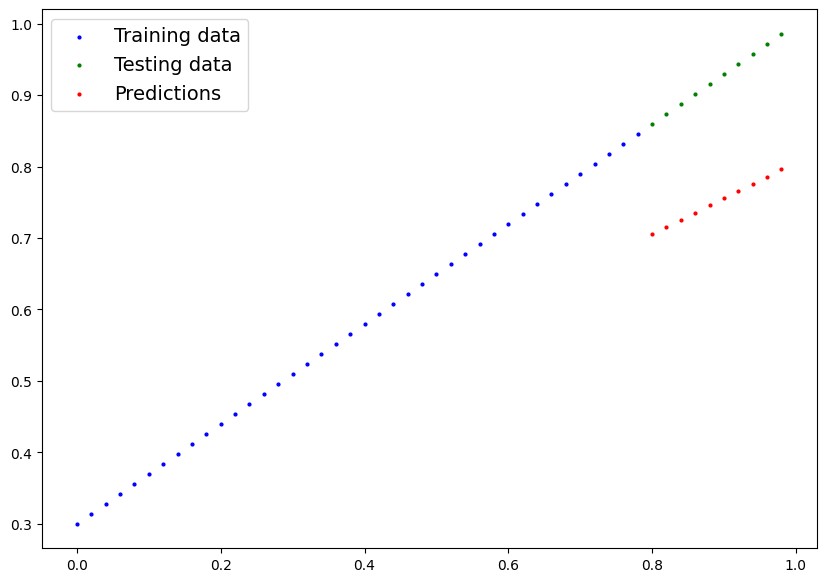

In [1555]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu(),
)

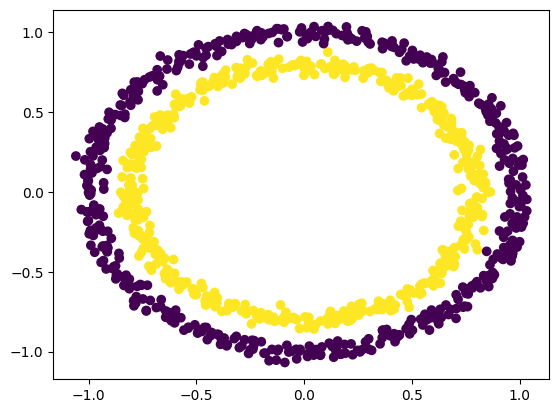

In [1556]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [1557]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1558]:
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)

In [1559]:
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

In [1560]:
epochs = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {test_loss:.5f}")
            print(f"accuracy: {acc:.2f} | test_accuracy: {test_acc:.2f}")

epoch: 0 | loss: 0.69295 | test_loss: 0.69319
accuracy: 50.00 | test_accuracy: 50.00
epoch: 10 | loss: 0.69248 | test_loss: 0.69260
accuracy: 50.50 | test_accuracy: 50.00
epoch: 20 | loss: 0.69225 | test_loss: 0.69231
accuracy: 59.13 | test_accuracy: 56.50
epoch: 30 | loss: 0.69209 | test_loss: 0.69212
accuracy: 70.25 | test_accuracy: 68.00
epoch: 40 | loss: 0.69195 | test_loss: 0.69195
accuracy: 68.38 | test_accuracy: 71.00
epoch: 50 | loss: 0.69181 | test_loss: 0.69177
accuracy: 58.25 | test_accuracy: 58.00
epoch: 60 | loss: 0.69168 | test_loss: 0.69161
accuracy: 54.00 | test_accuracy: 54.50
epoch: 70 | loss: 0.69155 | test_loss: 0.69146
accuracy: 53.12 | test_accuracy: 53.00
epoch: 80 | loss: 0.69141 | test_loss: 0.69132
accuracy: 52.62 | test_accuracy: 53.00
epoch: 90 | loss: 0.69128 | test_loss: 0.69117
accuracy: 52.75 | test_accuracy: 53.00
epoch: 100 | loss: 0.69115 | test_loss: 0.69102
accuracy: 52.88 | test_accuracy: 52.50
epoch: 110 | loss: 0.69103 | test_loss: 0.69088
accura

In [1561]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

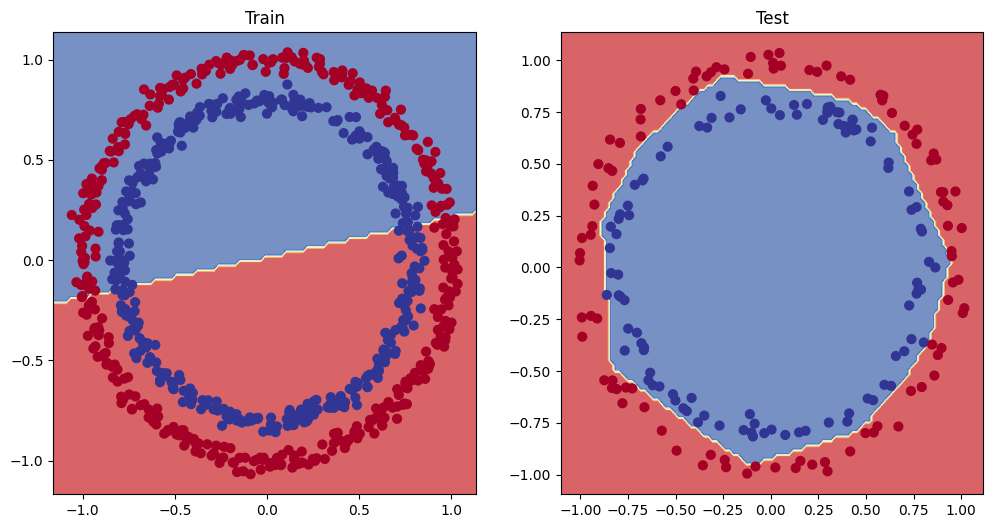

In [1562]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Making non-linear function

In [1563]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

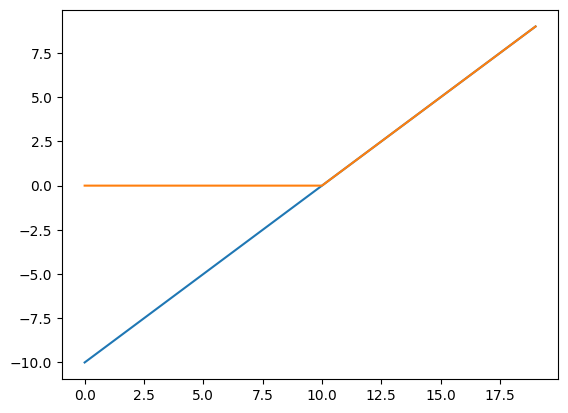

In [1564]:
plt.plot(A)
plt.plot(torch.relu(A))

In [1565]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)


relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

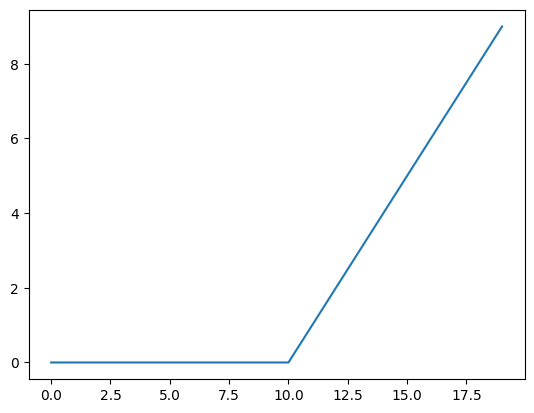

In [1566]:
plt.plot(relu(A))

In [1567]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

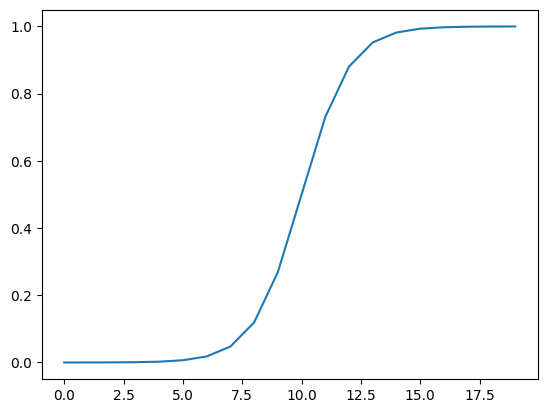

In [1568]:
plt.plot(torch.sigmoid(A))

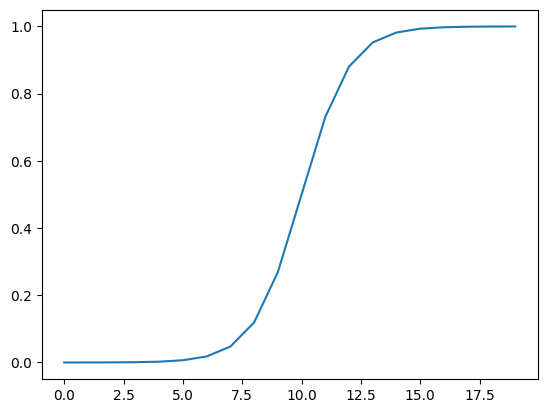

In [1569]:
plt.plot(sigmoid(A))

## Building Multiclass model

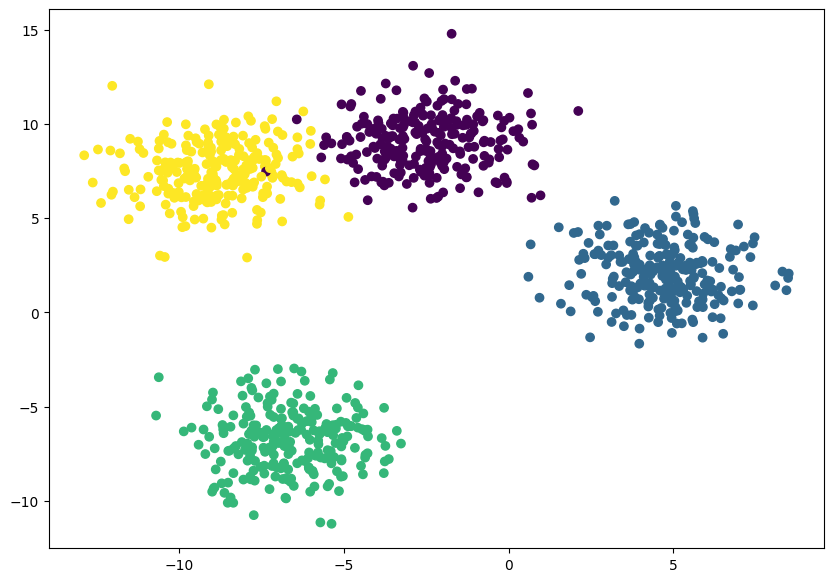

In [1615]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [1616]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using " + device)

using cuda


In [1617]:
from torch import nn


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multiclass classification model

        Args:
          input_features (int): Numpber of input features to the model
          output_features (int): Number of output features (number of output classes)
          hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [1618]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [1619]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [1620]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [1621]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [1622]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]], device='cuda:0')

In [1623]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [1624]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 1000

for epoch in range(EPOCHS):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {test_loss:.5f}")
            print(f"accuracy: {acc:.2f} | test_accuracy: {test_acc:.2f}")

epoch: 0 | loss: 1.15883 | test_loss: 1.07554
accuracy: 40.38 | test_accuracy: 48.00
epoch: 10 | loss: 0.64476 | test_loss: 0.66069
accuracy: 96.75 | test_accuracy: 97.50
epoch: 20 | loss: 0.42535 | test_loss: 0.43074
accuracy: 98.50 | test_accuracy: 100.00
epoch: 30 | loss: 0.25294 | test_loss: 0.24508
accuracy: 99.12 | test_accuracy: 99.50
epoch: 40 | loss: 0.11232 | test_loss: 0.10229
accuracy: 99.25 | test_accuracy: 99.50
epoch: 50 | loss: 0.06627 | test_loss: 0.05848
accuracy: 99.25 | test_accuracy: 99.50
epoch: 60 | loss: 0.05068 | test_loss: 0.04293
accuracy: 99.25 | test_accuracy: 99.50
epoch: 70 | loss: 0.04300 | test_loss: 0.03491
accuracy: 99.25 | test_accuracy: 99.50
epoch: 80 | loss: 0.03836 | test_loss: 0.02988
accuracy: 99.25 | test_accuracy: 99.50
epoch: 90 | loss: 0.03525 | test_loss: 0.02663
accuracy: 99.25 | test_accuracy: 99.50
epoch: 100 | loss: 0.03312 | test_loss: 0.02433
accuracy: 99.25 | test_accuracy: 99.50
epoch: 110 | loss: 0.03160 | test_loss: 0.02261
accur

In [1625]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8976, -12.3324,  -8.4675],
        [ -2.7724, -11.1928,  -7.4741,   6.3900],
        [ -4.3608,  -4.5814,   4.6890,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6638,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]], device='cuda:0')

In [1626]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

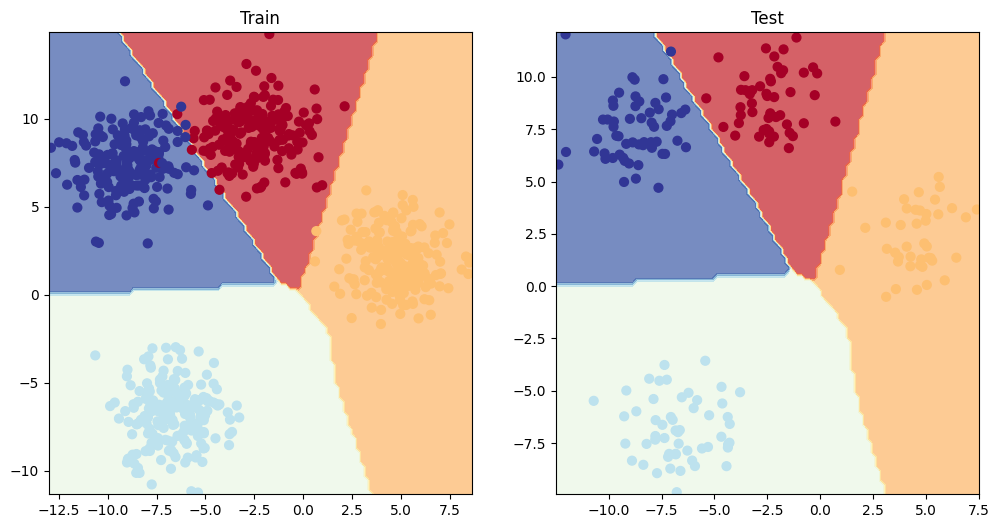

In [1627]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [1634]:
import torchmetrics

accuracy = torchmetrics.functional.accuracy(
    y_preds, y_blob_test, task="multiclass", num_classes=4
)

accuracy

tensor(0.9950, device='cuda:0')